In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
import string
import re
import zipfile, os
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')

import keras
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.models import Model
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D
# from keras.layers import MaxPooling2D, Conv2D, SpatialDropout2D, GlobalMaxPooling2D
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras.optimizers import SGD
from keras import initializers, regularizers, constraints, callbacks


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using TensorFlow backend.


In [0]:

stop_words = set(stopwords.words('english')) # + list(string.punctuation)
stemmer = SnowballStemmer(language='english')
def clean(text):
  tokens = []
  for word in nltk.word_tokenize(text):
      word = word.lower()
      if word not in stop_words and not word.isnumeric():
          tokens.append(stemmer.stem(word))
  tokens = " ".join(tokens)
  return tokens

  

In [0]:

train = pd.read_csv('drive/My Drive/train.csv')
valid = pd.read_csv('drive/My Drive/test.csv')
traintext = train.iloc[:,1]
stars = train.iloc[:,0]
y_train = train['stars'].apply(int)-1
y_valid = valid['stars'].apply(int)-1
y_train = keras.utils.to_categorical(y_train, num_classes=5)
y_valid = keras.utils.to_categorical(y_valid, num_classes=5)
    
X_train = train['text'].apply(clean)
X_valid = valid['text'].apply(clean)
max_features = 100000
maxlen = 300
embed_size = 100

           
tokenizer = text.Tokenizer(num_words=max_features) 
tokenizer.fit_on_texts(list(X_train) + list(X_valid))
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_valid = sequence.pad_sequences(X_valid, maxlen=maxlen)

word_index = tokenizer.word_index

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(100000, 300)
(10000, 300)
(100000, 5)
(10000, 5)


In [0]:

embeddings_index = dict()
f = open('drive/My Drive/glove.6B.100d.txt','r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))



nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words+1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

In [0]:

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

def schedule(ind):
    a = [0.001]
    return a[ind] 



session_conf = tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
K.set_session(tf.Session(graph=tf.get_default_graph(), config=session_conf))

#model
filter_nr = 64  #paper 250
filter_size = 3
max_pool_size = 3
max_pool_strides = 2
dense_nr = 256
spatial_dropout = 0.2
dense_dropout = 0.5
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)

comment = Input(shape=(maxlen,))
input_size = min(len(word_index)+1,max_features+1)
# emb_comment = Embedding(input_size, embed_size, weights=[embedding_matrix], trainable=train_embed)(comment)
emb_comment = Embedding(len(word_index)+1, embed_size)(comment)
emb_comment = SpatialDropout1D(spatial_dropout)(emb_comment)

block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)
block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)

#we pass embedded comment through conv1d with filter size 1 because it needs to have the same shape as block output
#if you choose filter_nr = embed_size (300 in this case) you don't have to do this part and can add emb_comment directly to block1_output
resize_emb = Conv1D(filter_nr, kernel_size=1, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
resize_emb = PReLU()(resize_emb)

block1_output = add([block1, resize_emb   ]) #emb_comment
block1_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)

block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1_output)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
    
block2_output = add([block2, block1_output])
block2_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2_output)
block3 = BatchNormalization()(block3)
block3 = PReLU()(block3)
block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3)
block3 = BatchNormalization()(block3)
block3 = PReLU()(block3)
    
block3_output = add([block3, block2_output])
block3_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output)

block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3_output)
block4 = BatchNormalization()(block4)
block4 = PReLU()(block4)
block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4)
block4 = BatchNormalization()(block4)
block4 = PReLU()(block4)

block4_output = add([block4, block3_output])
block4_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block4_output)

block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4_output)
block5 = BatchNormalization()(block5)
block5 = PReLU()(block5)
block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5)
block5 = BatchNormalization()(block5)
block5 = PReLU()(block5)

block5_output = add([block5, block4_output])
block5_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block5_output)

block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5_output)
block6 = BatchNormalization()(block6)
block6 = PReLU()(block6)
block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6)
block6 = BatchNormalization()(block6)
block6 = PReLU()(block6)

block6_output = add([block6, block5_output])
block6_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block6_output)

block7 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6_output)
block7 = BatchNormalization()(block7)
block7 = PReLU()(block7)
block7 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block7)
block7 = BatchNormalization()(block7)
block7 = PReLU()(block7)

block7_output = add([block7, block6_output])

output = GlobalMaxPooling1D()(block7_output)


output = Dense(dense_nr, activation='linear')(output)
output = BatchNormalization()(output)
output = PReLU()(output)
output = Dropout(dense_dropout)(output)
output = Dense(5, activation='sigmoid')(output)

model = Model(comment, output)

# optimizers = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
            optimizer=optimizers.Adam(),
            metrics=['accuracy'])
            
batch_size = 128
epochs = 30





Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

lr = callbacks.LearningRateScheduler(schedule)
ra_val = RocAucEvaluation(validation_data=(X_valid, y_valid), interval = 1)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid),callbacks = callbacks_list,verbose=1)  





Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 100000 samples, validate on 10000 samples
Epoch 1/30
100000/100000 [==============================] - 144s 1ms/step - loss: 1.0675 - acc: 0.5666 - val_loss: 0.8713 - val_acc: 0.6381

Epoch 00001: val_acc improved from -inf to 0.63810, saving model to weights.best.hdf5
Epoch 2/30
100000/100000 [==============================] - 130s 1ms/step - loss: 0.7827 - acc: 0.6739 - val_loss: 0.8096 - val_acc: 0.6621

Epoch 00002: val_acc improved from 0.63810 to 0.66210, saving model to weights.best.hdf5
Epoch 3/30
100000/100000 [==============================] - 129s 1ms/step - loss: 0.6823 - acc: 0.7169 - val_loss: 0.8849 - val_acc: 0.6534

Epoch 00003: val_acc did not improve from 0.66210
Epoch 4/30
100000/100000 [==============================] - 128s 1ms/step - loss: 0.5861 - acc: 0.7602 - val_loss: 1.1662 - val_acc: 0.6200

Epoch 00004: val_acc did not impro

In [0]:
from google.colab import files
files.download('weights.best.hdf5')

KeyboardInterrupt: ignored

10000/10000 [==============================] - 2s 170us/step
train_score:[0.057040183151960376, 0.98698] valid_score:[2.382526601409912, 0.606]
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


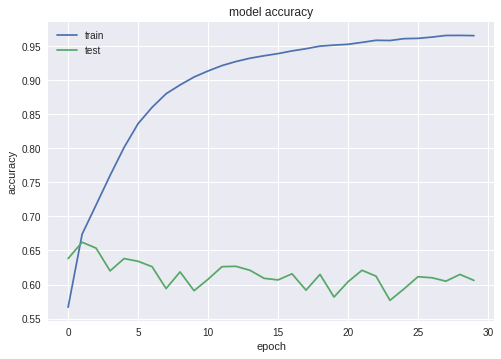

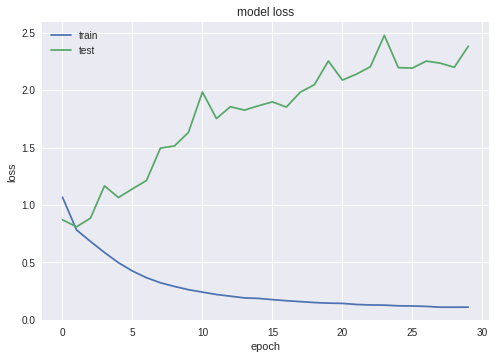

In [0]:
train_score = model.evaluate(X_train, y_train, batch_size=batch_size)
valid_score = model.evaluate(X_valid, y_valid, batch_size=batch_size)
print('train_score:{} valid_score:{}'.format(train_score,valid_score))

import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [0]:
test = pd.read_csv('drive/My Drive/test.csv')

X_test = test['text'].apply(clean)           
tokenizer = text.Tokenizer(num_words=max_features) 
tokenizer.fit_on_texts(list(X_test))
X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

y_pred = model.predict(X_test, batch_size=batch_size).argmax(axis=-1) + 1
sub_df = pd.DataFrame()
sub_df["pre"] = y_pred
sub_df



,pre
0,1
1,4
2,5
3,5
4,4
5,3
6,4
7,2
8,4
9,4


In [0]:
sub_df.to_csv('pre.csv', index=False)
files.download('pre.csv')